In [94]:
import warnings
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Topic Modelling

## 1. Creating dataframe

In [1]:
import pandas as pd

Read CSVs corresponding to Cordis and NSF datasets. Only the columns of interest are imported.

In [23]:
## Cordis

cordish2020 = pd.read_csv("data/cordis/cordis-h2020projects.csv",sep=";",usecols=['id','objective'])
cordisfp6 = pd.read_csv("data/cordis/cordis-fp6projects.csv",sep=";",usecols=['id','objective'])
cordisfp7 = pd.read_csv("data/cordis/cordis-fp7projects.csv",sep=";",usecols=['id','objective'])
cordis = cordish2020.append(cordisfp7)
cordis = cordis.append(cordisfp6)

print('Cordis null abstracts: %d (%.4f %%)' % (cordis['objective'].isnull().sum(),cordis['objective'].isnull().sum()/cordis.shape[0]))
print('Cordis shape with null abstracts: ',cordis.shape)
cordis = cordis[cordis['objective'].notna()]
print('Cordis shape without null abstracts: ',cordis.shape)
cordis['objective'].isnull().sum()

Cordis null abstracts: 160 (0.0024 %)
Cordis shape with null abstracts:  (68021, 2)
Cordis shape without null abstracts:  (67861, 2)


0

In [27]:
## NSF

nsf = pd.read_csv('data/nsf/nsf.csv',usecols=['AwardID','AbstractNarration'])

print('NSF null abstracts: %d (%.4f %%)' % (nsf['AbstractNarration'].isnull().sum(),nsf['AbstractNarration'].isnull().sum()/nsf.shape[0]))
print('NSF shape with null abstracts: ',nsf.shape)
nsf = nsf[nsf['AbstractNarration'].notna()]
print('NSF shape without null abstracts: ',nsf.shape)
nsf['AbstractNarration'].isnull().sum()

NSF null abstracts: 7857 (0.0114%)
NSF shape with null abstracts:  (688506, 2)
NSF shape without null abstracts:  (680649, 2)


0

In [28]:
# Add column with source of documents
cordis['org'] = 'EU'
nsf['org'] = 'NSF'

# Rename columns to match headers later
cordis = cordis.rename(columns={'objective':'abstract'})
nsf = nsf.rename(columns={'AwardID':'id','AbstractNarration':'abstract'})

# Join dataframes into 1
corpusdata = cordis.append(nsf)
corpusdata

,id,abstract,org
0,672890,'The project targets all luxury fashion firms ...,EU
1,633814,EU's agricultural and forestry land provides a...,EU
2,785419,"According to the Global Market Forecast, there...",EU
3,721362,In the aerospace industry very high quality st...,EU
4,861924,Large areas of agricultural land in W. and N. ...,EU
...,...,...,...
688501,1.61448e+06,A few micro-seconds after the Big Bang the uni...,NSF
688502,1.62455e+06,Calcium sulfate in crystalline form (anhydrite...,NSF
688503,1.6047e+06,The Rocky Mountain-Great Plains Graduate Resea...,NSF
688504,1.65392e+06,Investments made across national boundaries cr...,NSF


In [30]:
import numpy as np
idx_random = np.random.choice(corpusdata.shape[0], 10000, replace=False)
corpus_sample = corpusdata.iloc[idx_random, :]
corpus_sample

,id,abstract,org
318575,500568,<br/><br/>The PI intends to study Golod-Shafar...,NSF
69763,1.25683e+06,"This research addresses how leaf, stem and roo...",NSF
643979,203359,This theoretical project explores the fundamen...,NSF
348756,1.03793e+06,The 2010 M=7.0 Haiti earthquake ruptured a 40 ...,NSF
2743,1.84098e+06,This award supports 78 graduate and undergradu...,NSF
...,...,...,...
13659,1.91833e+06,The emergence of large-scale data-driven machi...,NSF
11468,851504,The applicant has an outstanding track record ...,EU
76117,640642,The overall objective of this project is to de...,NSF
288239,600384,This grant provides funding for research on a ...,NSF


In [31]:
corpus_sample.org.value_counts()

NSF    9071
EU      929
Name: org, dtype: int64

## 2. Lemmatization with Spacy

In [32]:
import spacy

In [33]:
nlp = spacy.load('en_core_web_md')
nlp.disable_pipe('parser')
nlp.disable_pipe('ner')

valid_POS = set(['VERB', 'NOUN', 'ADJ', 'PROPN'])

def text_preprocessing(rawtext):
    lemmatized = ' '.join([token.lemma_ for token in doc 
                           if token.is_alpha
                           and token.pos_ in valid_POS
                           and not token.is_stop)
    return lemmatized

In [135]:
corpus_sample['lemmas'] = None

for i in range(len(corpus_sample)):
    if not i%1000:
        print('Preprocessing abstract %d out of %d' % (i,len(corpus_sample['abstract'])))
    doc = nlp(corpus_sample['abstract'].iloc[i])
    corpus_sample['lemmas'].iloc[i] = text_preprocessing(doc)

corpus_sample.head()

Preprocessing abstract 0 out of 8602
Preprocessing abstract 1000 out of 8602
Preprocessing abstract 2000 out of 8602
Preprocessing abstract 3000 out of 8602
Preprocessing abstract 4000 out of 8602
Preprocessing abstract 5000 out of 8602
Preprocessing abstract 6000 out of 8602
Preprocessing abstract 7000 out of 8602
Preprocessing abstract 8000 out of 8602


,id,abstract,org,lemmas,nlemmas,clean_lemmas
1,1256827,"This research addresses how leaf, stem and roo...",NSF,address leaf root trait influence organismal r...,238,address leaf root trait influence organismal r...
3,1037930,The 2010 M=7.0 Haiti earthquake ruptured a 40 ...,NSF,Haiti earthquake rupture km long fault seismic...,115,haiti earthquake rupture km long fault seismic...
4,1840980,This award supports 78 graduate and undergradu...,NSF,award support student study participate co loc...,159,award support student study participate co loc...
5,693398,The aim of the project is to take the ground-b...,EU,aim project ground break step present static p...,151,aim project ground break step present static p...
6,1942250,As vertebrates moved into new ecological space...,NSF,vertebrate move new ecological space skull div...,268,vertebrate move new ecological space skull div...


In [36]:
corpus_sample.to_csv('data/corpus_sample_lemmatized.csv',sep=';',index=False)

corpus_sample = pd.read_csv('data/corpus_sample_lemmatized.csv',sep=';',dtype={'id':'int'})
corpus_sample

,id,abstract,org,lemmas
0,500568,<br/><br/>The PI intends to study Golod-Shafar...,NSF,PI intend study Golod Shafarevich group algebr...
1,1256827,"This research addresses how leaf, stem and roo...",NSF,research address leaf stem root trait influenc...
2,203359,This theoretical project explores the fundamen...,NSF,theoretical project explore fundamental physic...
3,1037930,The 2010 M=7.0 Haiti earthquake ruptured a 40 ...,NSF,Haiti earthquake rupture km long fault seismic...
4,1840980,This award supports 78 graduate and undergradu...,NSF,award support graduate undergraduate student s...
...,...,...,...,...
9995,1918327,The emergence of large-scale data-driven machi...,NSF,emergence large scale data drive machine learn...
9996,851504,The applicant has an outstanding track record ...,EU,applicant outstanding track record grow intern...
9997,640642,The overall objective of this project is to de...,NSF,overall objective project develop implement st...
9998,600384,This grant provides funding for research on a ...,NSF,grant provide funding research novel paradigm ...


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

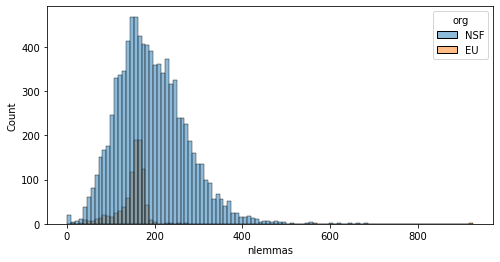

In [38]:
def count_lemmas(x):
    return len(x.split())

corpus_sample = corpus_sample[corpus_sample['lemmas'].notna()]
corpus_sample['nlemmas'] = corpus_sample['lemmas'].apply(count_lemmas)
fig, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
sns.histplot(data = corpus_sample, x='nlemmas', hue='org')
plt.show()

In [39]:
print('EU >= 100: ',len(corpus_sample[(corpus_sample['org']=='EU') & (corpus_sample['nlemmas']>=100)]))
print('EU < 100: ',len(corpus_sample[(corpus_sample['org']=='EU') & (corpus_sample['nlemmas']<100)]))

EU >= 100:  843
EU < 100:  86


In [40]:
print('NSF >= 100: ',len(corpus_sample[(corpus_sample['org']=='NSF') & (corpus_sample['nlemmas']>=100)]))
print('NSF < 100: ',len(corpus_sample[(corpus_sample['org']=='NSF') & (corpus_sample['nlemmas']<100)]))

NSF >= 100:  8233
NSF < 100:  838


In [41]:
corpus_sample = corpus_sample[corpus_sample['nlemmas']>=100]
print('Number of projects after removing short abstracts:', len(corpus_sample))

Number of projects after removing short abstracts: 9076


## 3. Vectorization with Gensim

In [42]:
import gensim

In [43]:
corpuslemmas = corpus_sample.lemmas.tolist()
corpuslemmas = list(set(corpuslemmas)) # project order lost at this point
corpuslemmas = [el.split() for el in corpuslemmas]

# Create dictionary of tokens
D = gensim.corpora.Dictionary(corpuslemmas)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 47614 terms
First terms in the dictionary:
0 : Bioinorganic
1 : C
2 : Chemistry
3 : F
4 : Frederick
5 : HFCs
6 : Inorganic
7 : Lewis
8 : Louisville
9 : Luzzio


In [44]:
no_below = 5 #Minimum number of documents to keep a term in the dictionary
no_above = .4 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

# D.filter_extremes(no_below=no_below,no_above=no_above, keep_n=25000)
D.filter_extremes(no_below=no_below,no_above=no_above) # keep all
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 11996 terms
First terms in the dictionary:
0 : Bioinorganic
1 : C
2 : Chemistry
3 : F
4 : Inorganic
5 : Lewis
6 : Louisville
7 : Organometallic
8 : Professor
9 : University


In [45]:
corpusbow = [D.doc2bow(doc) for doc in corpuslemmas]

### Initial topic model

In [46]:
from gensim.models.wrappers import LdaMallet
from customMallet import CustomMallet

In [47]:
mallet_path = '/Users/celiaromerogonzalez/Mallet/bin/mallet'
ldamallet = LdaMallet(mallet_path, corpus=corpusbow, num_topics=20, id2word=D, alpha=5, iterations=100)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


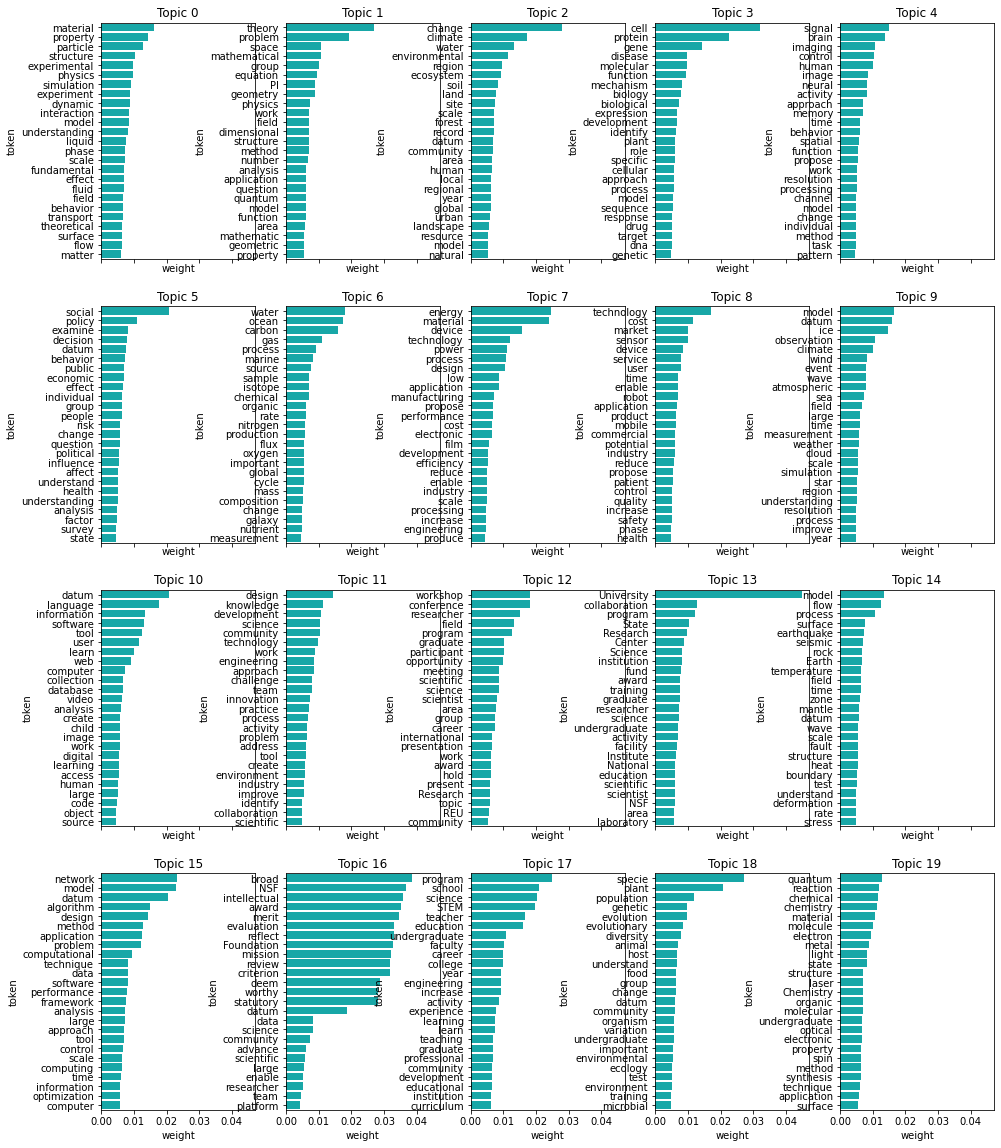

In [48]:
topn = 25

fig, axes = plt.subplots(4, 5, figsize=(16, 20), sharex=True)

for i in range(5):

    # Build a dataframe with columns 'token' and 'weight' for topic i
    df = pd.DataFrame(ldamallet.show_topic(i, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[0][i])
    axes[0][i].set_title('Topic ' + str(i))
    # Build a dataframe with columns 'token' and 'weight' for topic i + 5
    df = pd.DataFrame(ldamallet.show_topic(i+5, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[1][i])
    axes[1][i].set_title('Topic ' + str(i+5))
    # Build a dataframe with columns 'token' and 'weight' for topic i + 10
    df = pd.DataFrame(ldamallet.show_topic(i+10, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[2][i])
    axes[2][i].set_title('Topic ' + str(i+10))
    # Build a dataframe with columns 'token' and 'weight' for topic i + 15
    df = pd.DataFrame(ldamallet.show_topic(i + 15, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[3][i])
    axes[3][i].set_title('Topic ' + str(i + 15))
    
plt.show()

In [96]:
mytopics = pd.DataFrame(columns=['topic','word'])

In [101]:
for i in range(len(ldamallet.show_topics(num_topics=topn,formatted=False))):
    for j in range(len(ldamallet.show_topics(num_topics=topn,formatted=False)[i][1])):
        new_row = {'topic':ldamallet.show_topics(num_topics=topn,formatted=False)[i][0],'word':ldamallet.show_topics(num_topics=topn,formatted=False)[i][1][j][0]}
        mytopics = mytopics.append(new_row,ignore_index=True)

In [105]:
mytopics.to_excel('mytopics.xlsx',index=False)

### Cleaning vocabulary

In [107]:
specific_stw = ['activity','approach',
                'career','center','challenge','change','collaboration','college','conference','cost',
                'datum','design',
                'education','enable','engineering','examine','experiment',
                'faculty',
                'graduate','group',
                'individual','institution',
                'knowledge',
                'low',
                'material','meeting','method','model',
                'opportunity',
                'participant','problem','process','program','public',
                'research','researcher',
                'scale','school','science','scientific','site','stem',
                'teacher','technology','tool',
                'undergraduate','understand','university','user',
                'work','workshop']

In [109]:
def clean_lemmas(orig_str):
    lemmas = orig_str.lower().split()
    lemmas = [el for el in lemmas if el not in specific_stw]
    return ' '.join(lemmas)

corpus_sample['clean_lemmas'] = corpus_sample['lemmas'].apply(clean_lemmas)

#We filter again according to the number of lemmas
corpus_sample['nlemmas'] = corpus_sample['clean_lemmas'].apply(count_lemmas)
corpus_sample = corpus_sample[corpus_sample['nlemmas']>=100]
print('Number of projects in DataFrame after applying specific stopwords and removing short texts:', len(corpus_sample))

Number of projects in DataFrame after applying specific stopwords and removing short texts: 8602


In [113]:
mycorpus = corpus_sample.clean_lemmas.tolist()
mycorpus = list(set(mycorpus)) #Note that at this point we lose the project order
mycorpus = [el.split() for el in mycorpus]

# Create dictionary of tokens
D = gensim.corpora.Dictionary(mycorpus)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

no_below = 5 #Minimum number of documents to keep a term in the dictionary
no_above = .4 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below,no_above=no_above, keep_n=25000)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 40028 terms
First terms in the dictionary:
0 : achievement
1 : action
2 : adopt
3 : affordance
4 : aim
5 : alliance
6 : analyze
7 : application
8 : apply
9 : area
The dictionary contains 10650 terms
First terms in the dictionary:
0 : achievement
1 : action
2 : adopt
3 : affordance
4 : aim
5 : alliance
6 : analyze
7 : application
8 : apply
9 : area


In [114]:
corpus_sample.to_excel('corpus_sample.xlsx', index=False)
D.save('clean_gensim_sample.dict')

## 4. Topic modeling

### 4.1 Validating number of topics using coherence

In [116]:
#corpus_sample = pd.read_excel('corpus_sample.xlsx')
#D = gensim.corpora.Dictionary.load('clean_gensim_sample.dict')

In [117]:
mycorpus = corpus_sample.clean_lemmas.tolist()
mycorpus = list(set(mycorpus)) #Note that at this point we lose the project order
mycorpus = [el.split() for el in mycorpus]
mycorpus_bow = [D.doc2bow(doc) for doc in mycorpus]

Estimating coherence for a model with 5 topics
[0.4158905196478354]
Estimating coherence for a model with 10 topics
[0.4158905196478354, 0.5276774026159593]
Estimating coherence for a model with 15 topics
[0.4158905196478354, 0.5276774026159593, 0.5667107391652355]
Estimating coherence for a model with 20 topics
[0.4158905196478354, 0.5276774026159593, 0.5667107391652355, 0.5722385571583805]
Estimating coherence for a model with 25 topics
[0.4158905196478354, 0.5276774026159593, 0.5667107391652355, 0.5722385571583805, 0.5720654824605981]
Estimating coherence for a model with 35 topics
[0.4158905196478354, 0.5276774026159593, 0.5667107391652355, 0.5722385571583805, 0.5720654824605981, 0.592345294773587]
Estimating coherence for a model with 50 topics
[0.4158905196478354, 0.5276774026159593, 0.5667107391652355, 0.5722385571583805, 0.5720654824605981, 0.592345294773587, 0.5840268077057441]
Estimating coherence for a model with 75 topics
[0.4158905196478354, 0.5276774026159593, 0.566710739

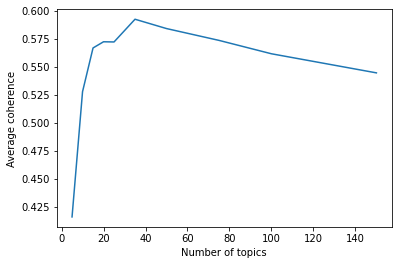

In [118]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel

n_topics = [5, 10, 15, 20, 25, 35, 50, 75, 100, 150]
tc = []
for ntpc in n_topics:
    print('Estimating coherence for a model with', ntpc, 'topics')
    lda_ntpc = LdaMallet(mallet_path, corpus=mycorpus_bow, num_topics=ntpc, id2word=D, alpha=5, iterations=250)
    ldagensim = malletmodel2ldamodel(lda_ntpc)
    tc.append(CoherenceModel(ldagensim, texts=mycorpus, dictionary=D, coherence='c_v').get_coherence())
    print(tc)

plt.plot(n_topics, tc)
plt.xlabel('Number of topics')
plt.ylabel('Average coherence')
plt.show()

In [131]:
print('Maximum coherence (%f) is achieved with %d topics' % (max(tc),n_topics[tc.index(max(tc))]))

Maximum coherence (0.592345) is achieved with 35 topics


### 4.2 Document LDA representation

In [120]:
import gensim
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel

#corpus_sample = pd.read_excel('corpus_sample.xlsx')
#D = gensim.corpora.Dictionary.load('clean_gensim_sample.dict')

In [121]:
mycorpus = corpus_sample.clean_lemmas.tolist()
mycorpus = list(set(mycorpus)) #Note that at this point we lose the project order
mycorpus = [el.split() for el in mycorpus]
mycorpus_bow = [D.doc2bow(doc) for doc in mycorpus]
ldamallet = LdaMallet(mallet_path, corpus=mycorpus_bow, num_topics=35, id2word=D, alpha=5, iterations=1000)

In [122]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

In [132]:
ldagensim = malletmodel2ldamodel(ldamallet)
vis_data = gensimvis.prepare(ldagensim, mycorpus_bow, D)
pyLDAvis.display(vis_data)

In [ ]:
tpc_descriptions = []

for ntpc in range(35):
    print(ldagensim.show_topic(ntpc, topn=20))
    desc = input('Introduce a label for topic ' + str(ntpc) + ': ')
    tpc_descriptions.append(desc)

In [ ]:
mycorpus = corpus_sample.clean_lemmas.tolist()
mycorpus = [el.split() for el in mycorpus]
mycorpus_bow = [D.doc2bow(doc) for doc in mycorpus]
mycorpus_lda = [ldagensim[el] for el in mycorpus_bow]

In [ ]:
main_topic = [tpc_descriptions[sorted(el,key=lambda x: -x[-1])[0][0]] for el in mycorpus_lda]

In [ ]:
corpus_sample['LDA_35'] = mycorpus_lda
corpus_sample['main_topic_35'] = main_topic

In [ ]:
NSF_df.to_excel('corpus_sample_35topics.xlsx', index=False)